In [1]:
#load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from nltk.util import ngrams
from functools import reduce
from scipy import stats
from ast import literal_eval
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
#load processed data
df = pd.read_csv('new2_lddf.csv', converters = {
    'description': literal_eval, 'host_about': literal_eval, 
    'bigram_description': literal_eval, 'bigram_host_about': literal_eval})

In [3]:
#delete unnecessary col
df = df.drop('Unnamed: 0', axis = 1)

In [4]:
#take a look at the shape of the dataframe
df.shape

(14676, 45)

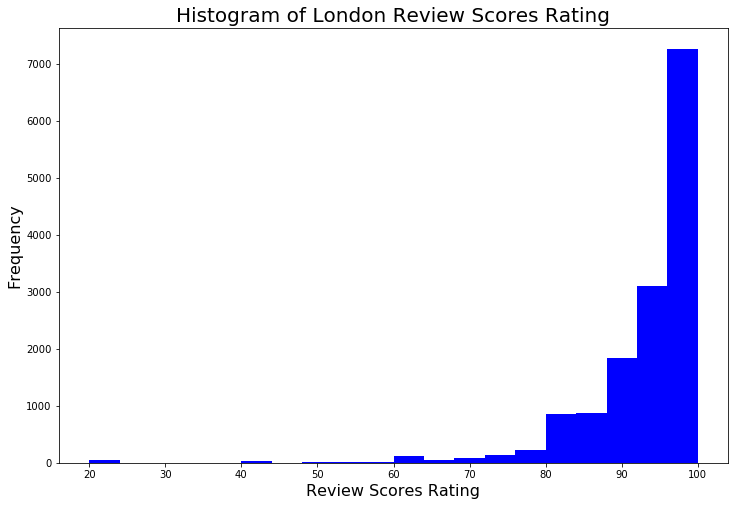

In [5]:
#plot local review score
plt.figure(figsize=(12,8))
plt.hist(df['review_scores_rating'], bins=20, color='b')
plt.title('Histogram of London Review Scores Rating', fontsize = 20)
plt.xlabel("Review Scores Rating", fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)


plt.savefig('londonreview.png')
plt.show()

In [6]:
print('The mean review scores rating is', df['review_scores_rating'].mean())
print("Percentage of Airbnb home rating less than 90 in London: {}%".format(round(sum(df.review_scores_rating < 85)/len(df),2)*100))
print("Percentage of Airbnb home rating being 100 in London:{}%".format(round(sum(df.review_scores_rating == 100)/len(df),2)*100))

The mean review scores rating is 92.97962660125374
Percentage of Airbnb home rating less than 90 in London: 12.0%
Percentage of Airbnb home rating being 100 in London:19.0%


In [7]:
df.amenities  #have a look at amenities

0        {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1        {TV,Wifi,Kitchen,"Paid parking off premises",E...
2        {TV,Wifi,Kitchen,"Free parking on premises",El...
3        {Wifi,Kitchen,"Pets live on this property",Cat...
4        {TV,"Cable TV",Internet,Wifi,Kitchen,Breakfast...
                               ...                        
14671    {TV,"Cable TV",Wifi,Kitchen,Heating,Washer,Dry...
14672    {TV,Kitchen,Heating,Washer,"Smoke detector",Es...
14673    {TV,Wifi,Kitchen,"Free parking on premises",He...
14674    {TV,Wifi,Kitchen,"Pets allowed",Heating,Washer...
14675    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
Name: amenities, Length: 14676, dtype: object

In [8]:
#handling amenities information
df.amenities = df.amenities.replace(to_replace = '["\d\s\-\/{\}]', value='', regex=True)
#a dummy dictionary for ameninties 
#containing all the amenities from all rows
amenities = {}
def itemfind(info):
    start = 0
    for idx, character in enumerate(info):
        if character == ",":
            if info[start:idx] not in amenities:  #each amenity as a key, an empty list as value
                amenities[info[start:idx]] = []
            start = idx+1
    if info[start:] not in amenities: #handling the last piece
            amenities[info[start:]] = []    
df.amenities.apply(lambda x: itemfind(x))

0        None
1        None
2        None
3        None
4        None
         ... 
14671    None
14672    None
14673    None
14674    None
14675    None
Name: amenities, Length: 14676, dtype: object

In [9]:
#binary label: if this amenity exist in this particular row, label as 1, else label as 0
count=0
def label(info):
    global amenities  #the dictionary 
    start = 0
    for idx, character in enumerate(info):
        if character == ",":
            if info[start:idx] in amenities:
                amenities[info[start:idx]].append(1)  #if it exists, label as 1
    global count
    count+=1
    for k,v in amenities.items():
        if len(v) < count: #if it is in the dict but not in the row, label as 0
            amenities[k].append(0)

df.amenities.apply(lambda x: label(x))

0        None
1        None
2        None
3        None
4        None
         ... 
14671    None
14672    None
14673    None
14674    None
14675    None
Name: amenities, Length: 14676, dtype: object

In [10]:
#new dataframe based on amenities dictionary
df2 = pd.DataFrame(amenities)
df = df.reset_index()
df = pd.concat([df, df2], axis=1, sort=False)
keys = list(amenities.keys())

In [11]:
keys  #take a look at what keys we have

['TV',
 'CableTV',
 'Internet',
 'Wifi',
 'Airconditioning',
 'Kitchen',
 'Buzzerwirelessintercom',
 'Heating',
 'Washer',
 'Dryer',
 'Smokedetector',
 'Fireextinguisher',
 'Essentials',
 'Shampoo',
 'hourcheckin',
 'Hangers',
 'Hairdryer',
 'Iron',
 'Laptopfriendlyworkspace',
 'translationmissing:en.hosting_amenity_',
 'Hotwater',
 'Microwave',
 'Coffeemaker',
 'Refrigerator',
 'Dishesandsilverware',
 'Cookingbasics',
 'Luggagedropoffallowed',
 'Longtermstaysallowed',
 'Other',
 'Paidparkingoffpremises',
 'Elevator',
 'Familykidfriendly',
 'Selfcheckin',
 'Lockbox',
 'Bedlinens',
 'Dishwasher',
 'Oven',
 'Stove',
 'Freeparkingonpremises',
 'Carbonmonoxidedetector',
 'Lockonbedroomdoor',
 'Hostgreetsyou',
 'Petsliveonthisproperty',
 'Cat(s)',
 'Freestreetparking',
 'Buildingstaff',
 'Breakfast',
 'Firstaidkit',
 'Safetycard',
 'Roomdarkeningshades',
 'Extrapillowsandblankets',
 'Gardenorbackyard',
 'Indoorfireplace',
 'Privatelivingroom',
 'Privateentrance',
 'BBQgrill',
 'Patioorbalco

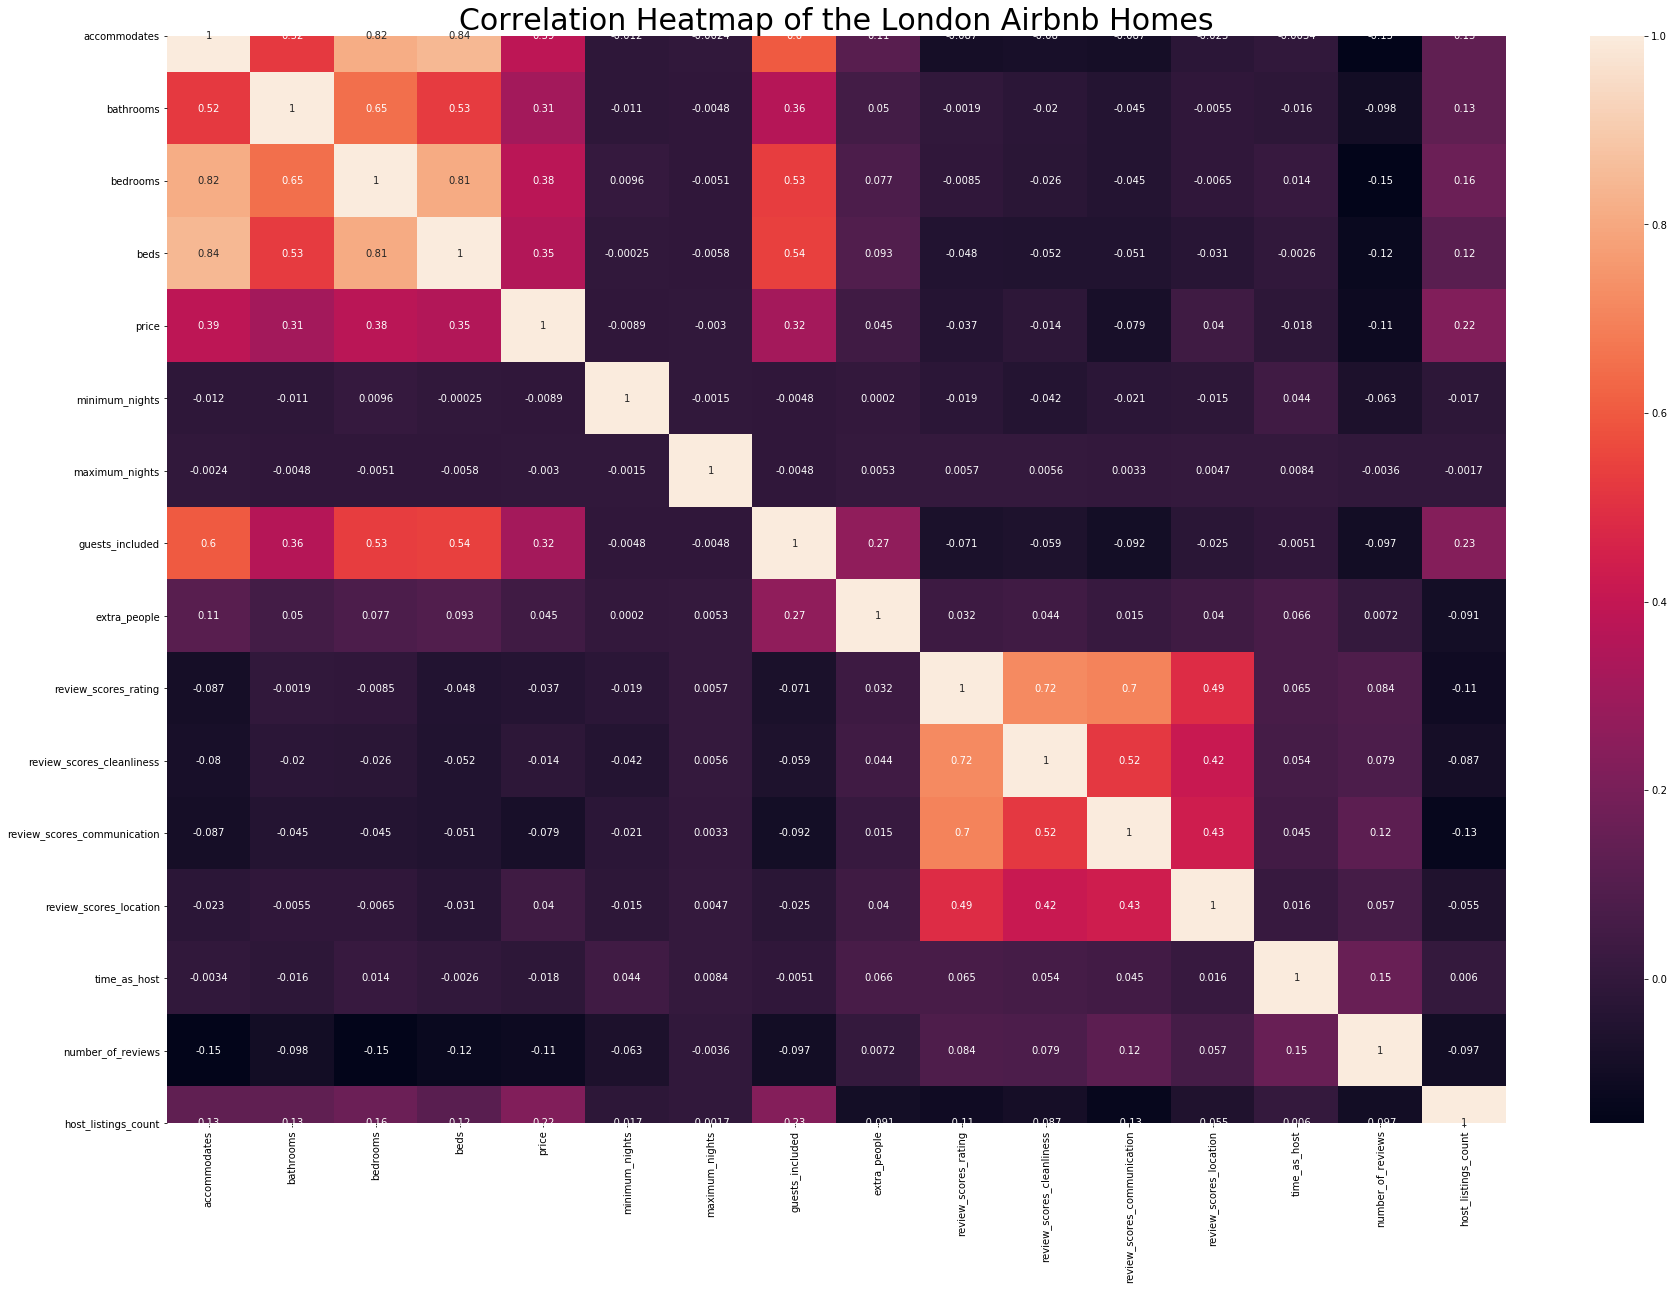

In [12]:
#heatmap
plt.rcParams['figure.figsize'] = (30, 20)
sns.heatmap(df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',              
              'maximum_nights', 'guests_included', 'extra_people','review_scores_rating', 
               'review_scores_cleanliness', 'review_scores_communication',
               'review_scores_location', 'time_as_host', 'number_of_reviews','host_listings_count']].corr(), annot = True)

plt.title('Correlation Heatmap of the London Airbnb Homes', fontsize = 30)

plt.savefig('heatmaplondon.png')

In [13]:
#merge the two text info to one text
df['description'] = df['description'].apply(lambda x: ' '.join(x))
df['host_about'] = df['host_about'].apply(lambda x: ' '.join(x))
df['description_host'] = df['description'] + ' ' + df['host_about']

In [14]:
df['description_host']  #have a look at the combined one 

0        lot window light st luke garden end block rive...
1        wonderful stay superb modern recently refurbis...
2        large comfort flat first floor lift pretty com...
3        walking distance twickenham stadium min drive ...
4        situated literally london field park moment li...
                               ...                        
14671    newly refurbished guest house offer great valu...
14672    cosy place rest head homely close goodmayes tr...
14673    hanover house serviced apartment located brent...
14674    offering upscale designer sqft flat located ar...
14675    heart paddington walk station chic home ideal ...
Name: description_host, Length: 14676, dtype: object

In [15]:
#select features, target and split the dataset into train/test set
X = df[['description_host', 'accommodates', 'bathrooms', 'beds', 'bedrooms', 'price',
               'guests_included', 'extra_people','minimum_nights',              
              'maximum_nights', 'number_of_reviews', 'review_scores_location',
               'review_scores_cleanliness', 'review_scores_communication', 
               'time_as_host', 'host_response_rate','host_acceptance_rate', 'transit', 'host_has_profile_pic', 
               'host_identity_verified', 
                   'neighbourhood', 'property_type', 'room_type', 'bed_type', 
                   'security_deposit', 'cleaning_fee', 'instant_bookable',
                   'weekly_price', 'host_is_superhost', 'host_response_time'] + keys]
y = df[['review_scores_rating']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [16]:
#numeric attributes and pipeline building
numeric_data = ['accommodates', 'bathrooms', 'beds', 'bedrooms', 'price',
               'guests_included', 'extra_people','minimum_nights',              
              'maximum_nights', 'number_of_reviews', 'review_scores_location',
               'review_scores_cleanliness', 'review_scores_communication', 
               'time_as_host', 'host_response_rate','host_acceptance_rate' ]
numeric_pipe = Pipeline([('scale', StandardScaler())])

#categorical attributes and pipeline building 
categorical_data = ['transit', 'host_has_profile_pic', 'host_identity_verified', 
                   'neighbourhood', 'property_type', 'room_type', 'bed_type', 
                   'security_deposit', 'cleaning_fee', 'instant_bookable',
                   'weekly_price', 'host_is_superhost', 'host_response_time'] + keys
categorical_pipe = Pipeline([('onehot', OneHotEncoder(sparse=False, handle_unknown = 'ignore')), 
                     ('varthres', VarianceThreshold(threshold = 0.97*(1-0.97)))])

In [17]:
#text attributes and pipeline building 
text_data = 'description_host'
text_pipe1 = Pipeline([('Count', CountVectorizer(max_features = 10000, min_df = 0.0015, ngram_range = (1,2)))])
text_pipe2 = Pipeline([('Tfid', TfidfVectorizer(max_features = 10000, min_df = 0.0015, ngram_range = (1,2)))])

In [18]:
#build two preprocessors
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_data),
        ('cat', categorical_pipe, categorical_data),
        ('text1', text_pipe1, text_data)])
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_data),
        ('cat', categorical_pipe, categorical_data),
        ('text2', text_pipe2, text_data)])

### 1. Ridge with bag of words

In [19]:
#create the first pipeline(with bag of words) 
pipe1 = Pipeline(steps=[('preprocessor', preprocessor1),
                      ('regressor', Ridge())])

param_grid = {'regressor__alpha': np.logspace(-1,3, num = 50)}

clf1 = RandomizedSearchCV(pipe1, param_grid, cv = 5, verbose = 15, n_iter = 10, 
                           scoring = 'r2', n_jobs = 4, random_state = 123)

clf1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   56.2s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   56.4s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   56.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  2.2min
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [20]:
#the parameters
print('optimzed paramters;', clf1.best_params_)

optimzed paramters; {'regressor__alpha': 28.11768697974228}


In [21]:
y_pred = clf1.predict(X_test)

#report the performance metric
train_r2 = round(clf1.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error', mae)

Training set r2: 0.84
Testing set r2: 0.61
Mean square error 29.1
Mean absolute error 3.66


In [22]:
#get feature importance
r1importance=[]
temp = clf1.best_estimator_['regressor'].coef_
for i in temp:
    for j in i:
        r1importance.append(j)

p1ohe_label = clf1.best_estimator_['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names()

p1boolean_feature_used = clf1.best_estimator_['preprocessor'].named_transformers_['cat']['varthres'].get_support()

p1cat_used = []

for idx, boolean in enumerate(p1boolean_feature_used):
    if boolean:
        p1cat_used.append(p1ohe_label[idx])


p1voc_used = list(clf1.best_estimator_['preprocessor'].named_transformers_['text1']['Count'].vocabulary_.keys()) 

p1labels = numeric_data+p1cat_used + p1voc_used        

In [23]:
p1ohe_label    #take a look at the encoded categorical features for pipeline1, to understand what the symbols stand for 

array(['x0_False', 'x0_True', 'x1_f', 'x1_t', 'x2_f', 'x2_t', 'x3_Acton',
       'x3_Balham', 'x3_Battersea', 'x3_Bayswater', 'x3_Beckenham',
       'x3_Belgravia', 'x3_Bellingham', 'x3_Bermondsey',
       'x3_Bethnal Green', 'x3_Blackheath', 'x3_Bloomsbury', 'x3_Bow',
       'x3_Brixton', 'x3_Brockley', 'x3_Bromley-by-Bow', 'x3_Camberwell',
       'x3_Camden Town', 'x3_Canonbury', 'x3_Catford', 'x3_Chelsea',
       'x3_City of London', 'x3_City of Westminster', 'x3_Clapham',
       'x3_Clerkenwell', 'x3_Covent Garden', 'x3_Crystal Palace',
       'x3_Dalston', 'x3_De Beauvoir Town', 'x3_Deptford', 'x3_Downham',
       'x3_Dulwich', 'x3_Dulwich Village', 'x3_Earls Court',
       'x3_Earlsfield', 'x3_East Dulwich', 'x3_Fitzrovia',
       'x3_Forest Hill', 'x3_Fulham', 'x3_Furzedown', 'x3_Globe Town',
       'x3_Greenwich', 'x3_Grove Park', 'x3_Hackney', 'x3_Haggerston',
       'x3_Hammersmith', 'x3_Hampstead', 'x3_Herne Hill',
       'x3_Hither Green', 'x3_Holborn', 'x3_Holland Park', '

In [24]:
print('Number of feature importance in the first pipeline: {}'.format(len(r1importance)))
print('Number of labels in the first pipeline: {}'.format(len(p1labels)))

Number of feature importance in the first pipeline: 10051
Number of labels in the first pipeline: 10051


In [25]:
#sort the labels by importance
r1sorted_importance = sorted(list(zip(p1labels, r1importance)), key = lambda x: abs(x[1]), reverse = True)

#sorted labels and sorted feature importance
r1sort_label = []
r1sort_importance = []
for label, value in r1sorted_importance:
    r1sort_label.append(label)
    r1sort_importance.append(value)

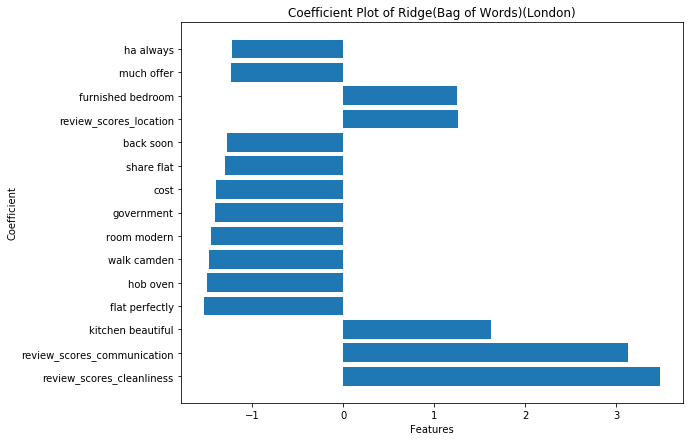

In [26]:
#plot
plt.figure(figsize = (9,7))
plt.barh(r1sort_label[:15], r1sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')  
plt.title('Coefficient Plot of Ridge(Bag of Words)(London)')
plt.savefig('londonr1.png')

In [27]:
data={'feature':r1sort_label[:15],'ridge(bad of words)':r1sort_importance[:15]}
r1df=pd.DataFrame(data) 
r1df

,feature,ridge(bad of words)
0,review_scores_cleanliness,3.484939
1,review_scores_communication,3.130619
2,kitchen beautiful,1.626500
3,flat perfectly,-1.536597
4,hob oven,-1.499507
5,walk camden,-1.479074
6,room modern,-1.450935
7,government,-1.410651
8,cost,-1.405379
9,share flat,-1.303574


### 2. Ridge with tfidf

In [28]:
#create the second pipeline(with tfidf) 
pipe2 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('regressor', Ridge())])

clf2 = RandomizedSearchCV(pipe2, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   32.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   32.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   44.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   45.0s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   45.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   55.9s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   56.0s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   56.6s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [29]:
print('Optimzed parameters:', clf2.best_params_)

Optimzed parameters: {'regressor__alpha': 0.6551285568595507}


In [30]:
y_pred = clf2.predict(X_test)

In [31]:
train_r2 = round(clf2.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.81
Testing set r2: 0.66
Mean square error: 25.55
Mean absolute error: 3.3


In [32]:
r2importance=[]
coeff = clf2.best_estimator_['regressor'].coef_
for i in coeff:
    for j in i:
        r2importance.append(j)

        
p2ohe_label = clf2.best_estimator_['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names()


p2boolean_feature_used = clf2.best_estimator_['preprocessor'].named_transformers_['cat']['varthres'].get_support()

p2cat_used = []

for idx, boolean in enumerate(p2boolean_feature_used):
    if boolean:
        p2cat_used.append(p2ohe_label[idx])

p2voc_used = list(clf2.best_estimator_['preprocessor'].named_transformers_['text2']['Tfid'].vocabulary_.keys()) 

p2labels = numeric_data+p2cat_used + p2voc_used       

In [33]:
p2ohe_label    #take a look at the encoded categorical features for pipeline2, to understand what the symbols stand fo

array(['x0_False', 'x0_True', 'x1_f', 'x1_t', 'x2_f', 'x2_t', 'x3_Acton',
       'x3_Balham', 'x3_Battersea', 'x3_Bayswater', 'x3_Beckenham',
       'x3_Belgravia', 'x3_Bellingham', 'x3_Bermondsey',
       'x3_Bethnal Green', 'x3_Blackheath', 'x3_Bloomsbury', 'x3_Bow',
       'x3_Brixton', 'x3_Brockley', 'x3_Bromley-by-Bow', 'x3_Camberwell',
       'x3_Camden Town', 'x3_Canonbury', 'x3_Catford', 'x3_Chelsea',
       'x3_City of London', 'x3_City of Westminster', 'x3_Clapham',
       'x3_Clerkenwell', 'x3_Covent Garden', 'x3_Crystal Palace',
       'x3_Dalston', 'x3_De Beauvoir Town', 'x3_Deptford', 'x3_Downham',
       'x3_Dulwich', 'x3_Dulwich Village', 'x3_Earls Court',
       'x3_Earlsfield', 'x3_East Dulwich', 'x3_Fitzrovia',
       'x3_Forest Hill', 'x3_Fulham', 'x3_Furzedown', 'x3_Globe Town',
       'x3_Greenwich', 'x3_Grove Park', 'x3_Hackney', 'x3_Haggerston',
       'x3_Hammersmith', 'x3_Hampstead', 'x3_Herne Hill',
       'x3_Hither Green', 'x3_Holborn', 'x3_Holland Park', '

In [34]:
print('Number of feature importance in the second pipeline: {}'.format(len(r2importance)))
print('Number of labels in the second pipeline: {}'.format(len(p2labels)))

Number of feature importance in the second pipeline: 10051
Number of labels in the second pipeline: 10051


In [35]:
r2sorted_importance = sorted(list(zip(p2labels, r2importance)), key = lambda x: abs(x[1]), reverse = True)


r2sort_label = []
r2sort_importance = []
for label, value in r2sorted_importance:
    r2sort_label.append(label)
    r2sort_importance.append(value)

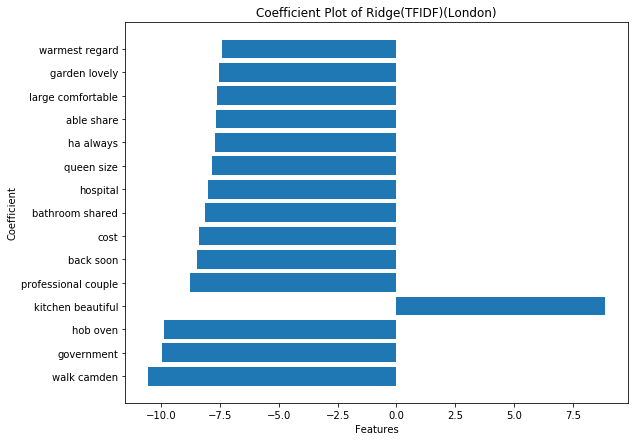

In [36]:
plt.figure(figsize = (9,7))
plt.barh(r2sort_label[:15], r2sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')  
plt.title('Coefficient Plot of Ridge(TFIDF)(London)')
plt.savefig('londonr2.png')

In [37]:
data={'feature':r2sort_label[:15],'ridge(TFIDF)':r2sort_importance[:15]}
r2df=pd.DataFrame(data) 
r2df

,feature,ridge(TFIDF)
0,walk camden,-10.560887
1,government,-9.953712
2,hob oven,-9.893350
3,kitchen beautiful,8.854857
4,professional couple,-8.787529
5,back soon,-8.504729
6,cost,-8.412489
7,bathroom shared,-8.149296
8,hospital,-8.007084
9,queen size,-7.825816


### 3. Lasso with bag of words

In [38]:
pipe3 = Pipeline(steps=[('preprocessor', preprocessor1),
                      ('regressor', Lasso())])


param_grid = {'regressor__alpha': np.logspace(-1,3, num = 50)}

clf3 = RandomizedSearchCV(pipe3, param_grid, cv = 5, verbose = 15, n_iter = 10, 
                           scoring = 'r2', n_jobs = 4, random_state = 123)

clf3.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   34.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   34.7s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   35.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   45.0s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   45.9s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [39]:
print('optimzed parameters:', clf3.best_params_)

optimzed parameters: {'regressor__alpha': 0.44984326689694454}


In [40]:
y_pred = clf3.predict(X_test)

In [41]:
train_r2 = round(clf3.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.68
Testing set r2: 0.66
Mean square error: 25.33
Mean absolute error: 3.2


In [42]:
l1importance= clf3.best_estimator_['regressor'].coef_


l1sorted_Importance = sorted(list(zip(p1labels, l1importance)), key = lambda x: abs(x[1]), reverse = True)


l1sort_label = []
l1sort_importance = []
for label, value in l1sorted_Importance:
    l1sort_label.append(label)
    l1sort_importance.append(value)

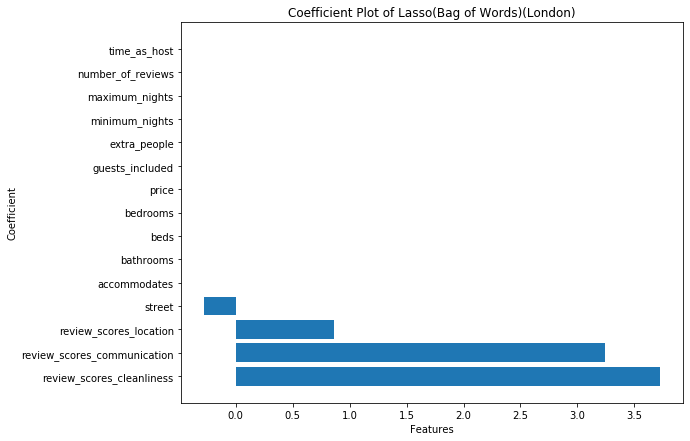

In [43]:
plt.figure(figsize = (9,7))
plt.barh(l1sort_label[:15], l1sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficient Plot of Lasso(Bag of Words)(London)')
plt.savefig('londonl1.png')

In [44]:
data={'feature':l1sort_label[:15],'lasso(bag of words)':l1sort_importance[:15]}
l1df=pd.DataFrame(data) 
l1df

,feature,lasso(bag of words)
0,review_scores_cleanliness,3.725473
1,review_scores_communication,3.242501
2,review_scores_location,0.860570
3,street,-0.279452
4,accommodates,-0.000000
5,bathrooms,0.000000
6,beds,0.000000
7,bedrooms,0.000000
8,price,0.000000
9,guests_included,0.000000


### 4. Lasso with tfidf

In [45]:
pipe4 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('regressor', Lasso())])

clf4 = RandomizedSearchCV(pipe4, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   34.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   34.8s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   35.8s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   45.4s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   46.0s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [46]:
print('optimzed parameters:', clf4.best_params_)

optimzed parameters: {'regressor__alpha': 0.44984326689694454}


In [47]:
y_pred = clf4.predict(X_test)

In [48]:
train_r2 = round(clf4.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.67
Testing set r2: 0.65
Mean square error: 25.86
Mean absolute error: 3.24


In [49]:
l2importance= clf4.best_estimator_['regressor'].coef_


l2sorted_Importance = sorted(list(zip(p2labels, l2importance)), key = lambda x: abs(x[1]), reverse = True)

l2sort_label = []
l2sort_importance = []
for label, value in l2sorted_Importance:
    l2sort_label.append(label)
    l2sort_importance.append(value)

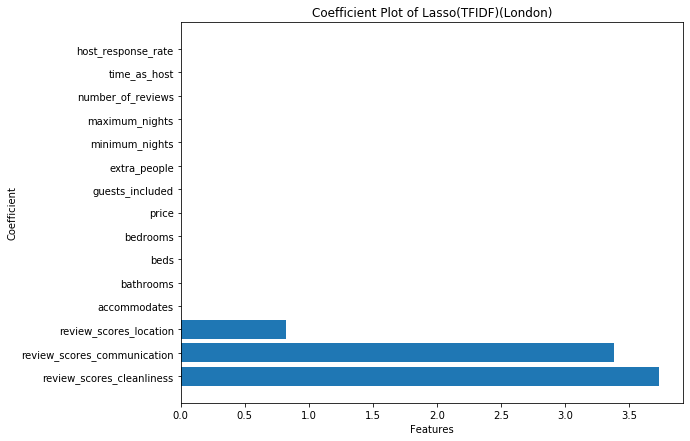

In [50]:
plt.figure(figsize = (9,7))
plt.barh(l2sort_label[:15], l2sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficient Plot of Lasso(TFIDF)(London)')
plt.savefig('londonl2.png')

In [51]:
data={'feature':l2sort_label[:15],'lasso(TFIDF)':l2sort_importance[:15]}
l2df=pd.DataFrame(data) 
l2df

,feature,lasso(TFIDF)
0,review_scores_cleanliness,3.735104
1,review_scores_communication,3.382070
2,review_scores_location,0.820763
3,accommodates,-0.000000
4,bathrooms,0.000000
5,beds,-0.000000
6,bedrooms,0.000000
7,price,-0.000000
8,guests_included,-0.000000
9,extra_people,0.000000


### 5. Random Forest

In [52]:
pipe5 = Pipeline([('preprocessor', preprocessor1),
                  ('regressor', RandomForestRegressor())])

param_grid = {'regressor__n_estimators': np.arange(8,17,2), 
              'regressor__min_samples_split': np.arange(2,6),
             'regressor__min_samples_leaf': np.arange(1,5)}

clf5 = RandomizedSearchCV(pipe5, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf5.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  9.5min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed: 13.2min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed: 13.3min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed: 13.7min
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [53]:
print('optimized parameters:', clf5.best_params_)

optimized parameters: {'regressor__n_estimators': 16, 'regressor__min_samples_split': 3, 'regressor__min_samples_leaf': 4}


In [54]:
y_pred = clf5.predict(X_test)

In [55]:
train_r2 = round(clf5.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.88
Testing set r2: 0.68
Mean square error: 23.69
Mean absolute error: 2.96


In [56]:
rfimportance = clf5.best_estimator_['regressor'].feature_importances_

rfsorted_importance = sorted(list(zip(p1labels, rfimportance)), key = lambda x: abs(x[1]), reverse = True)

rfsort_label = []
rfsort_importance = []
for label, value in rfsorted_importance:
    rfsort_label.append(label)
    rfsort_importance.append(value)

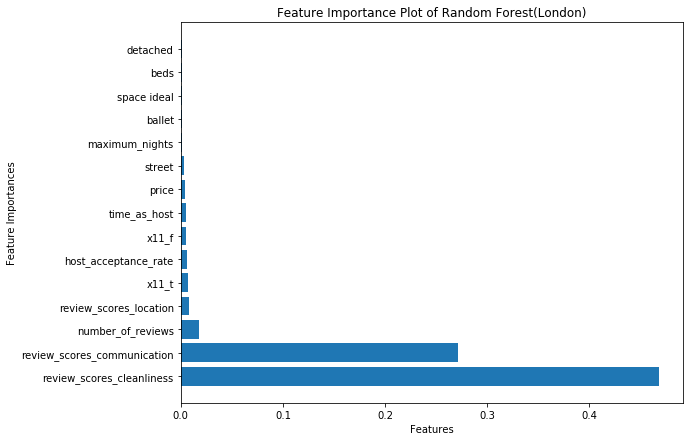

In [57]:
plt.figure(figsize = (9,7))
plt.barh(rfsort_label[:15], rfsort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature Importance Plot of Random Forest(London)')
plt.savefig('londonrf.png')   

In [58]:
data={'feature':rfsort_label[:15],'random forest':rfsort_importance[:15]}
rfdf=pd.DataFrame(data) 
rfdf

,feature,random forest
0,review_scores_cleanliness,0.468316
1,review_scores_communication,0.271681
2,number_of_reviews,0.017424
3,review_scores_location,0.008488
4,x11_t,0.006655
5,host_acceptance_rate,0.006124
6,x11_f,0.004665
7,time_as_host,0.004613
8,price,0.004462
9,street,0.002932


### 6. Gradient boosting

In [59]:
pipe6 = Pipeline([('preprocessor', preprocessor1), 
                  ('regressor', GradientBoostingRegressor())])

param_grid = {'regressor__n_estimators': [100, 200, 300, 400, 500],
              'regressor__learning_rate': [0.001, 0.01, 0.1, 0.3],
              'regressor__max_depth': np.arange(3,6),
              'regressor__alpha': np.arange(0,1,0.1)}


clf6 = RandomizedSearchCV(pipe6, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf6.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  7.6min
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [60]:
print('optimized parameters:', clf6.best_params_)

optimized parameters: {'regressor__n_estimators': 200, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.1, 'regressor__alpha': 0.4}


In [61]:
y_pred = clf6.predict(X_test)

In [62]:
train_r2 = round(clf6.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.84
Testing set r2: 0.69
Mean square error: 23.09
Mean absolute error: 2.94


In [63]:
gbimportance = clf6.best_estimator_['regressor'].feature_importances_

gbsorted_importance = sorted(list(zip(p1labels, gbimportance)), key = lambda x: abs(x[1]), reverse = True)

gbsort_label = []
gbsort_importance = []
for label, value in gbsorted_importance:
    gbsort_label.append(label)
    gbsort_importance.append(value)

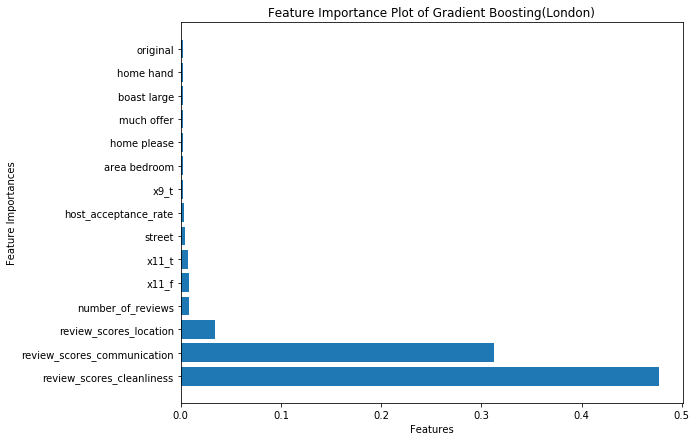

In [64]:
plt.figure(figsize = (9,7))
plt.barh(gbsort_label[:15], gbsort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature Importance Plot of Gradient Boosting(London)')
plt.savefig('londongb.png')

In [65]:
data={'feature':gbsort_label[:15],'gradient boosting':gbsort_importance[:15]}
gbdf=pd.DataFrame(data) 
gbdf

,feature,gradient boosting
0,review_scores_cleanliness,0.477479
1,review_scores_communication,0.313059
2,review_scores_location,0.034324
3,number_of_reviews,0.008099
4,x11_f,0.007872
5,x11_t,0.007456
6,street,0.003941
7,host_acceptance_rate,0.003153
8,x9_t,0.002494
9,area bedroom,0.002468


### 7. Important features analysis

In [66]:
data_frames = [r1df,r2df,l1df,l2df,rfdf,gbdf]

In [67]:
#the features ranking top15 in all the models. 
df_merged1 = reduce(lambda left,right: pd.merge(left,right,on='feature',
                                            how='inner'), data_frames)
df_merged1

,ridge(bad of words),ridge(TFIDF),lasso(bag of words),lasso(TFIDF),random forest,feature,gradient boosting


In [68]:
#the features ranking top15 in each model. 
df_merged2 = reduce(lambda left,right: pd.merge(left,right,on='feature',
                                            how='outer'), data_frames)
df_merged2

,feature,ridge(bad of words),ridge(TFIDF),lasso(bag of words),lasso(TFIDF),random forest,gradient boosting
0,review_scores_cleanliness,3.484939,NaN,3.725473,3.735104,0.468316,0.477479
1,review_scores_communication,3.130619,NaN,3.242501,3.382070,0.271681,0.313059
2,kitchen beautiful,1.626500,8.854857,NaN,NaN,NaN,NaN
3,flat perfectly,-1.536597,NaN,NaN,NaN,NaN,NaN
4,hob oven,-1.499507,-9.893350,NaN,NaN,NaN,NaN
5,walk camden,-1.479074,-10.560887,NaN,NaN,NaN,NaN
6,room modern,-1.450935,NaN,NaN,NaN,NaN,NaN
7,government,-1.410651,-9.953712,NaN,NaN,NaN,NaN
8,cost,-1.405379,-8.412489,NaN,NaN,NaN,NaN
9,share flat,-1.303574,NaN,NaN,NaN,NaN,NaN
